In [1]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-05 by mza
name = "mza_try8"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 3 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 9
inner_quantization = 9
output_quantization = 12

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.1934534782372811


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 788us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name', default_reuse_factor=9)
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       9
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_qdense_input
    Trace:           False
    Precision
   

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

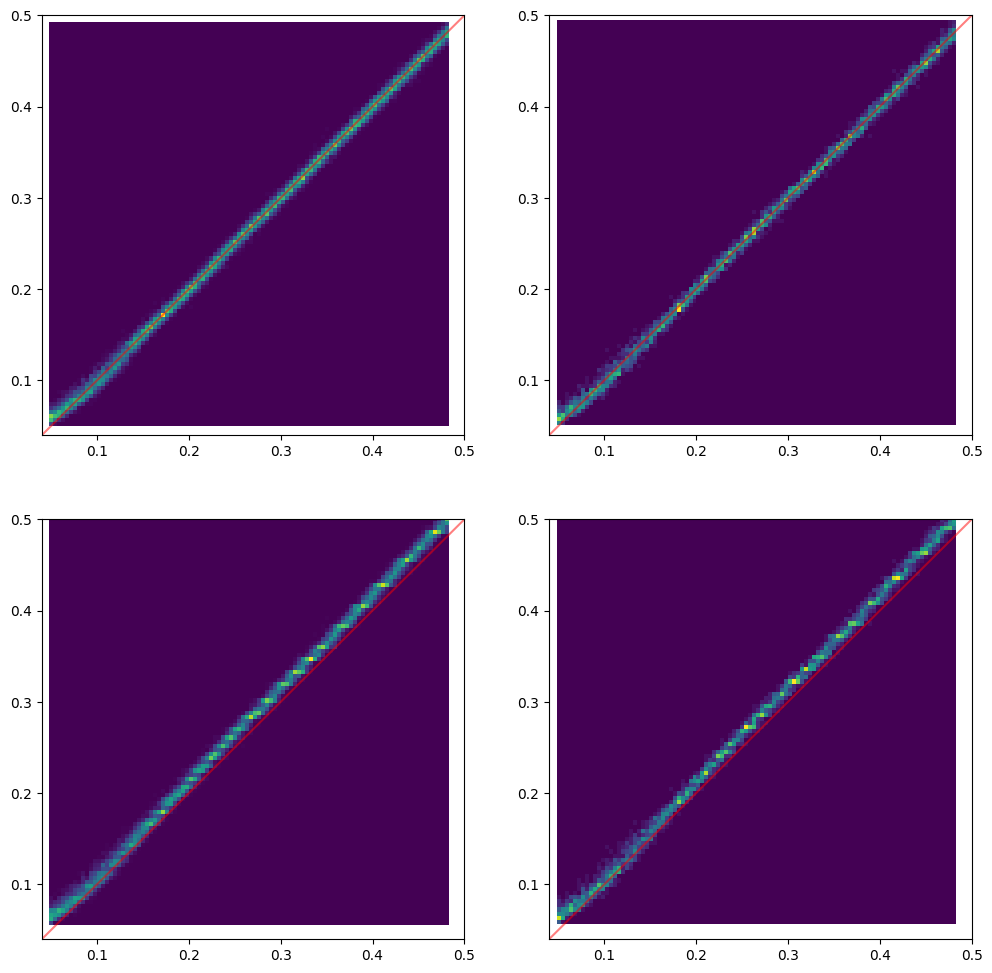

In [17]:
nbins = 100
a = 0.04; b = 0.5
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [18]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host '17425374c219' (Linux_x86_64 version 6.11.0-21-generic) on Tue May 06 00:23:38 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Opening project '/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj'.
INFO: [

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_mode

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 2.52 seconds. CPU system time: 0.05 seconds. Elapsed time: 2.57 seconds; current allocated memory: 1.196 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 2.4 seconds. CPU system time: 0 seconds. Elapsed time: 2.4 seconds; current allocated memory: 1.196 GB.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' into 'nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>' (firmware/nnet_utils/nnet_dense_latency.h:66) automatically.
INFO: [XFORM 203-602] Inlining function 'nnet::cast<ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config5>' into 'nnet::dense_latency<ap_ufixed<9, 0, (ap_q_mode)4, (ap_o_mode)0, 0>, ap_fixed<26, 10,

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'relu<ap_fixed<26, 10, 5, 3, 0>, ap_ufixed<9, 0, 4, 0, 0>, relu_config7>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 2, function 'relu<ap_fixed<26, 10, 5, 3, 0>, ap_ufixed<9, 0, 4, 0, 0>, relu_config7>'
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111] Finished Scheduling: CPU user time: 3.63 seconds. CPU system time: 0.06 seconds. Elapsed time: 3.69 seconds; current allocated memory: 2.201 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101]

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_ap_fixed_26_10_5_3_0_ap_ufixed_9_0_4_0_0_relu_config7_s'.
INFO: [HLS 200-111] Finished Creating RTL model: CPU user time: 43.73 seconds. CPU system time: 0.61 seconds. Elapsed time: 44.39 seconds; current allocated memory: 3.491 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_28_9_5_3_0_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_28_9_5_3_0_config8_s' pipeline 'dense_

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_9ns_11s_19_3_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_9ns_11s_19_3_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_9ns_10s_19_3_1.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_9ns_10s_19_3_1
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_5ns_21_2_0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_5ns_21_2_0
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/si

Starting static elaboration
Pass Through NonSizing Optimizer
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling package xil_defaultlib.$unit_dataflow_monitor_sv
Compiling module xil_defaultlib.myproject_mul_16s_6ns_22_2_1(NUM...
Compiling module xil_defaultlib.myproject_mul_16s_5ns_21_2_1(NUM...
Compiling module xil_defaultlib.myproject_mul_16s_6s_22_2_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_16s_5s_21_2_1(NUM_...
Compiling module xil_defaultlib.myproject_dense_latency_ap_fixed...
Compiling module xil_defaultlib.myproject_hard_sigmoid_ap_fixed_...
Compiling module xil_defaultlib.myproject_mul_9ns_6ns_14_3_1(NUM...
Compiling module xil_defaultlib.myproject_mul_9ns_5s_14_3_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_9ns_6s_15_3_1(NUM_...
Compiling module xil_defaultlib.myproject_mul_9ns_5ns_13_3_1(NUM...
Compiling module xil_defaultlib.myproject_mul_9ns_7s_1

// RTL Simulation : 31 / 4000 [78.57%] @ "1683000"
// RTL Simulation : 32 / 4000 [78.57%] @ "1728000"
// RTL Simulation : 33 / 4000 [78.57%] @ "1773000"
// RTL Simulation : 34 / 4000 [78.57%] @ "1818000"
// RTL Simulation : 35 / 4000 [78.57%] @ "1863000"
// RTL Simulation : 36 / 4000 [78.57%] @ "1908000"
// RTL Simulation : 37 / 4000 [78.57%] @ "1953000"
// RTL Simulation : 38 / 4000 [78.57%] @ "1998000"
// RTL Simulation : 39 / 4000 [78.57%] @ "2043000"
// RTL Simulation : 40 / 4000 [78.57%] @ "2088000"
// RTL Simulation : 41 / 4000 [78.57%] @ "2133000"
// RTL Simulation : 42 / 4000 [78.57%] @ "2178000"
// RTL Simulation : 43 / 4000 [78.57%] @ "2223000"
// RTL Simulation : 44 / 4000 [78.57%] @ "2268000"
// RTL Simulation : 45 / 4000 [78.57%] @ "2313000"
// RTL Simulation : 46 / 4000 [78.57%] @ "2358000"
// RTL Simulation : 47 / 4000 [78.57%] @ "2403000"
// RTL Simulation : 48 / 4000 [78.57%] @ "2448000"
// RTL Simulation : 49 / 4000 [78.57%] @ "2493000"
// RTL Simulation : 50 / 4000 [

// RTL Simulation : 198 / 4000 [78.57%] @ "9198000"
// RTL Simulation : 199 / 4000 [78.57%] @ "9243000"
// RTL Simulation : 200 / 4000 [78.57%] @ "9288000"
// RTL Simulation : 201 / 4000 [78.57%] @ "9333000"
// RTL Simulation : 202 / 4000 [78.57%] @ "9378000"
// RTL Simulation : 203 / 4000 [78.57%] @ "9423000"
// RTL Simulation : 204 / 4000 [78.57%] @ "9468000"
// RTL Simulation : 205 / 4000 [78.57%] @ "9513000"
// RTL Simulation : 206 / 4000 [78.57%] @ "9558000"
// RTL Simulation : 207 / 4000 [78.57%] @ "9603000"
// RTL Simulation : 208 / 4000 [78.57%] @ "9648000"
// RTL Simulation : 209 / 4000 [78.57%] @ "9693000"
// RTL Simulation : 210 / 4000 [78.57%] @ "9738000"
// RTL Simulation : 211 / 4000 [78.57%] @ "9783000"
// RTL Simulation : 212 / 4000 [78.57%] @ "9828000"
// RTL Simulation : 213 / 4000 [78.57%] @ "9873000"
// RTL Simulation : 214 / 4000 [78.57%] @ "9918000"
// RTL Simulation : 215 / 4000 [78.57%] @ "9963000"
// RTL Simulation : 216 / 4000 [78.57%] @ "10008000"
// RTL Simu

// RTL Simulation : 354 / 4000 [78.57%] @ "16218000"
// RTL Simulation : 355 / 4000 [78.57%] @ "16263000"
// RTL Simulation : 356 / 4000 [78.57%] @ "16308000"
// RTL Simulation : 357 / 4000 [78.57%] @ "16353000"
// RTL Simulation : 358 / 4000 [78.57%] @ "16398000"
// RTL Simulation : 359 / 4000 [78.57%] @ "16443000"
// RTL Simulation : 360 / 4000 [78.57%] @ "16488000"
// RTL Simulation : 361 / 4000 [78.57%] @ "16533000"
// RTL Simulation : 362 / 4000 [78.57%] @ "16578000"
// RTL Simulation : 363 / 4000 [78.57%] @ "16623000"
// RTL Simulation : 364 / 4000 [78.57%] @ "16668000"
// RTL Simulation : 365 / 4000 [78.57%] @ "16713000"
// RTL Simulation : 366 / 4000 [78.57%] @ "16758000"
// RTL Simulation : 367 / 4000 [78.57%] @ "16803000"
// RTL Simulation : 368 / 4000 [78.57%] @ "16848000"
// RTL Simulation : 369 / 4000 [78.57%] @ "16893000"
// RTL Simulation : 370 / 4000 [78.57%] @ "16938000"
// RTL Simulation : 371 / 4000 [78.57%] @ "16983000"
// RTL Simulation : 372 / 4000 [78.57%] @ "170

// RTL Simulation : 513 / 4000 [78.57%] @ "23373000"
// RTL Simulation : 514 / 4000 [78.57%] @ "23418000"
// RTL Simulation : 515 / 4000 [78.57%] @ "23463000"
// RTL Simulation : 516 / 4000 [78.57%] @ "23508000"
// RTL Simulation : 517 / 4000 [78.57%] @ "23553000"
// RTL Simulation : 518 / 4000 [78.57%] @ "23598000"
// RTL Simulation : 519 / 4000 [78.57%] @ "23643000"
// RTL Simulation : 520 / 4000 [78.57%] @ "23688000"
// RTL Simulation : 521 / 4000 [78.57%] @ "23733000"
// RTL Simulation : 522 / 4000 [78.57%] @ "23778000"
// RTL Simulation : 523 / 4000 [78.57%] @ "23823000"
// RTL Simulation : 524 / 4000 [78.57%] @ "23868000"
// RTL Simulation : 525 / 4000 [78.57%] @ "23913000"
// RTL Simulation : 526 / 4000 [78.57%] @ "23958000"
// RTL Simulation : 527 / 4000 [78.57%] @ "24003000"
// RTL Simulation : 528 / 4000 [78.57%] @ "24048000"
// RTL Simulation : 529 / 4000 [78.57%] @ "24093000"
// RTL Simulation : 530 / 4000 [78.57%] @ "24138000"
// RTL Simulation : 531 / 4000 [78.57%] @ "241

// RTL Simulation : 680 / 4000 [78.57%] @ "30888000"
// RTL Simulation : 681 / 4000 [78.57%] @ "30933000"
// RTL Simulation : 682 / 4000 [78.57%] @ "30978000"
// RTL Simulation : 683 / 4000 [78.57%] @ "31023000"
// RTL Simulation : 684 / 4000 [78.57%] @ "31068000"
// RTL Simulation : 685 / 4000 [78.57%] @ "31113000"
// RTL Simulation : 686 / 4000 [78.57%] @ "31158000"
// RTL Simulation : 687 / 4000 [78.57%] @ "31203000"
// RTL Simulation : 688 / 4000 [78.57%] @ "31248000"
// RTL Simulation : 689 / 4000 [78.57%] @ "31293000"
// RTL Simulation : 690 / 4000 [78.57%] @ "31338000"
// RTL Simulation : 691 / 4000 [78.57%] @ "31383000"
// RTL Simulation : 692 / 4000 [78.57%] @ "31428000"
// RTL Simulation : 693 / 4000 [78.57%] @ "31473000"
// RTL Simulation : 694 / 4000 [78.57%] @ "31518000"
// RTL Simulation : 695 / 4000 [78.57%] @ "31563000"
// RTL Simulation : 696 / 4000 [78.57%] @ "31608000"
// RTL Simulation : 697 / 4000 [78.57%] @ "31653000"
// RTL Simulation : 698 / 4000 [78.57%] @ "316

// RTL Simulation : 846 / 4000 [78.57%] @ "38358000"
// RTL Simulation : 847 / 4000 [78.57%] @ "38403000"
// RTL Simulation : 848 / 4000 [78.57%] @ "38448000"
// RTL Simulation : 849 / 4000 [78.57%] @ "38493000"
// RTL Simulation : 850 / 4000 [78.57%] @ "38538000"
// RTL Simulation : 851 / 4000 [78.57%] @ "38583000"
// RTL Simulation : 852 / 4000 [78.57%] @ "38628000"
// RTL Simulation : 853 / 4000 [78.57%] @ "38673000"
// RTL Simulation : 854 / 4000 [78.57%] @ "38718000"
// RTL Simulation : 855 / 4000 [78.57%] @ "38763000"
// RTL Simulation : 856 / 4000 [78.57%] @ "38808000"
// RTL Simulation : 857 / 4000 [78.57%] @ "38853000"
// RTL Simulation : 858 / 4000 [78.57%] @ "38898000"
// RTL Simulation : 859 / 4000 [78.57%] @ "38943000"
// RTL Simulation : 860 / 4000 [78.57%] @ "38988000"
// RTL Simulation : 861 / 4000 [78.57%] @ "39033000"
// RTL Simulation : 862 / 4000 [78.57%] @ "39078000"
// RTL Simulation : 863 / 4000 [78.57%] @ "39123000"
// RTL Simulation : 864 / 4000 [78.57%] @ "391

// RTL Simulation : 1001 / 4000 [78.57%] @ "45333000"
// RTL Simulation : 1002 / 4000 [78.57%] @ "45378000"
// RTL Simulation : 1003 / 4000 [78.57%] @ "45423000"
// RTL Simulation : 1004 / 4000 [78.57%] @ "45468000"
// RTL Simulation : 1005 / 4000 [78.57%] @ "45513000"
// RTL Simulation : 1006 / 4000 [78.57%] @ "45558000"
// RTL Simulation : 1007 / 4000 [78.57%] @ "45603000"
// RTL Simulation : 1008 / 4000 [78.57%] @ "45648000"
// RTL Simulation : 1009 / 4000 [78.57%] @ "45693000"
// RTL Simulation : 1010 / 4000 [78.57%] @ "45738000"
// RTL Simulation : 1011 / 4000 [78.57%] @ "45783000"
// RTL Simulation : 1012 / 4000 [78.57%] @ "45828000"
// RTL Simulation : 1013 / 4000 [78.57%] @ "45873000"
// RTL Simulation : 1014 / 4000 [78.57%] @ "45918000"
// RTL Simulation : 1015 / 4000 [78.57%] @ "45963000"
// RTL Simulation : 1016 / 4000 [78.57%] @ "46008000"
// RTL Simulation : 1017 / 4000 [78.57%] @ "46053000"
// RTL Simulation : 1018 / 4000 [78.57%] @ "46098000"
// RTL Simulation : 1019 / 4

// RTL Simulation : 1153 / 4000 [78.57%] @ "52173000"
// RTL Simulation : 1154 / 4000 [78.57%] @ "52218000"
// RTL Simulation : 1155 / 4000 [78.57%] @ "52263000"
// RTL Simulation : 1156 / 4000 [78.57%] @ "52308000"
// RTL Simulation : 1157 / 4000 [78.57%] @ "52353000"
// RTL Simulation : 1158 / 4000 [78.57%] @ "52398000"
// RTL Simulation : 1159 / 4000 [78.57%] @ "52443000"
// RTL Simulation : 1160 / 4000 [78.57%] @ "52488000"
// RTL Simulation : 1161 / 4000 [78.57%] @ "52533000"
// RTL Simulation : 1162 / 4000 [78.57%] @ "52578000"
// RTL Simulation : 1163 / 4000 [78.57%] @ "52623000"
// RTL Simulation : 1164 / 4000 [78.57%] @ "52668000"
// RTL Simulation : 1165 / 4000 [78.57%] @ "52713000"
// RTL Simulation : 1166 / 4000 [78.57%] @ "52758000"
// RTL Simulation : 1167 / 4000 [78.57%] @ "52803000"
// RTL Simulation : 1168 / 4000 [78.57%] @ "52848000"
// RTL Simulation : 1169 / 4000 [78.57%] @ "52893000"
// RTL Simulation : 1170 / 4000 [78.57%] @ "52938000"
// RTL Simulation : 1171 / 4

// RTL Simulation : 1305 / 4000 [78.57%] @ "59013000"
// RTL Simulation : 1306 / 4000 [78.57%] @ "59058000"
// RTL Simulation : 1307 / 4000 [78.57%] @ "59103000"
// RTL Simulation : 1308 / 4000 [78.57%] @ "59148000"
// RTL Simulation : 1309 / 4000 [78.57%] @ "59193000"
// RTL Simulation : 1310 / 4000 [78.57%] @ "59238000"
// RTL Simulation : 1311 / 4000 [78.57%] @ "59283000"
// RTL Simulation : 1312 / 4000 [78.57%] @ "59328000"
// RTL Simulation : 1313 / 4000 [78.57%] @ "59373000"
// RTL Simulation : 1314 / 4000 [78.57%] @ "59418000"
// RTL Simulation : 1315 / 4000 [78.57%] @ "59463000"
// RTL Simulation : 1316 / 4000 [78.57%] @ "59508000"
// RTL Simulation : 1317 / 4000 [78.57%] @ "59553000"
// RTL Simulation : 1318 / 4000 [78.57%] @ "59598000"
// RTL Simulation : 1319 / 4000 [78.57%] @ "59643000"
// RTL Simulation : 1320 / 4000 [78.57%] @ "59688000"
// RTL Simulation : 1321 / 4000 [78.57%] @ "59733000"
// RTL Simulation : 1322 / 4000 [78.57%] @ "59778000"
// RTL Simulation : 1323 / 4

// RTL Simulation : 1458 / 4000 [78.57%] @ "65898000"
// RTL Simulation : 1459 / 4000 [78.57%] @ "65943000"
// RTL Simulation : 1460 / 4000 [78.57%] @ "65988000"
// RTL Simulation : 1461 / 4000 [78.57%] @ "66033000"
// RTL Simulation : 1462 / 4000 [78.57%] @ "66078000"
// RTL Simulation : 1463 / 4000 [78.57%] @ "66123000"
// RTL Simulation : 1464 / 4000 [78.57%] @ "66168000"
// RTL Simulation : 1465 / 4000 [78.57%] @ "66213000"
// RTL Simulation : 1466 / 4000 [78.57%] @ "66258000"
// RTL Simulation : 1467 / 4000 [78.57%] @ "66303000"
// RTL Simulation : 1468 / 4000 [78.57%] @ "66348000"
// RTL Simulation : 1469 / 4000 [78.57%] @ "66393000"
// RTL Simulation : 1470 / 4000 [78.57%] @ "66438000"
// RTL Simulation : 1471 / 4000 [78.57%] @ "66483000"
// RTL Simulation : 1472 / 4000 [78.57%] @ "66528000"
// RTL Simulation : 1473 / 4000 [78.57%] @ "66573000"
// RTL Simulation : 1474 / 4000 [78.57%] @ "66618000"
// RTL Simulation : 1475 / 4000 [78.57%] @ "66663000"
// RTL Simulation : 1476 / 4

// RTL Simulation : 1613 / 4000 [78.57%] @ "72873000"
// RTL Simulation : 1614 / 4000 [78.57%] @ "72918000"
// RTL Simulation : 1615 / 4000 [78.57%] @ "72963000"
// RTL Simulation : 1616 / 4000 [78.57%] @ "73008000"
// RTL Simulation : 1617 / 4000 [78.57%] @ "73053000"
// RTL Simulation : 1618 / 4000 [78.57%] @ "73098000"
// RTL Simulation : 1619 / 4000 [78.57%] @ "73143000"
// RTL Simulation : 1620 / 4000 [78.57%] @ "73188000"
// RTL Simulation : 1621 / 4000 [78.57%] @ "73233000"
// RTL Simulation : 1622 / 4000 [78.57%] @ "73278000"
// RTL Simulation : 1623 / 4000 [78.57%] @ "73323000"
// RTL Simulation : 1624 / 4000 [78.57%] @ "73368000"
// RTL Simulation : 1625 / 4000 [78.57%] @ "73413000"
// RTL Simulation : 1626 / 4000 [78.57%] @ "73458000"
// RTL Simulation : 1627 / 4000 [78.57%] @ "73503000"
// RTL Simulation : 1628 / 4000 [78.57%] @ "73548000"
// RTL Simulation : 1629 / 4000 [78.57%] @ "73593000"
// RTL Simulation : 1630 / 4000 [78.57%] @ "73638000"
// RTL Simulation : 1631 / 4

// RTL Simulation : 1768 / 4000 [78.57%] @ "79848000"
// RTL Simulation : 1769 / 4000 [78.57%] @ "79893000"
// RTL Simulation : 1770 / 4000 [78.57%] @ "79938000"
// RTL Simulation : 1771 / 4000 [78.57%] @ "79983000"
// RTL Simulation : 1772 / 4000 [78.57%] @ "80028000"
// RTL Simulation : 1773 / 4000 [78.57%] @ "80073000"
// RTL Simulation : 1774 / 4000 [78.57%] @ "80118000"
// RTL Simulation : 1775 / 4000 [78.57%] @ "80163000"
// RTL Simulation : 1776 / 4000 [78.57%] @ "80208000"
// RTL Simulation : 1777 / 4000 [78.57%] @ "80253000"
// RTL Simulation : 1778 / 4000 [78.57%] @ "80298000"
// RTL Simulation : 1779 / 4000 [78.57%] @ "80343000"
// RTL Simulation : 1780 / 4000 [78.57%] @ "80388000"
// RTL Simulation : 1781 / 4000 [78.57%] @ "80433000"
// RTL Simulation : 1782 / 4000 [78.57%] @ "80478000"
// RTL Simulation : 1783 / 4000 [78.57%] @ "80523000"
// RTL Simulation : 1784 / 4000 [78.57%] @ "80568000"
// RTL Simulation : 1785 / 4000 [78.57%] @ "80613000"
// RTL Simulation : 1786 / 4

// RTL Simulation : 1925 / 4000 [78.57%] @ "86913000"
// RTL Simulation : 1926 / 4000 [78.57%] @ "86958000"
// RTL Simulation : 1927 / 4000 [78.57%] @ "87003000"
// RTL Simulation : 1928 / 4000 [78.57%] @ "87048000"
// RTL Simulation : 1929 / 4000 [78.57%] @ "87093000"
// RTL Simulation : 1930 / 4000 [78.57%] @ "87138000"
// RTL Simulation : 1931 / 4000 [78.57%] @ "87183000"
// RTL Simulation : 1932 / 4000 [78.57%] @ "87228000"
// RTL Simulation : 1933 / 4000 [78.57%] @ "87273000"
// RTL Simulation : 1934 / 4000 [78.57%] @ "87318000"
// RTL Simulation : 1935 / 4000 [78.57%] @ "87363000"
// RTL Simulation : 1936 / 4000 [78.57%] @ "87408000"
// RTL Simulation : 1937 / 4000 [78.57%] @ "87453000"
// RTL Simulation : 1938 / 4000 [78.57%] @ "87498000"
// RTL Simulation : 1939 / 4000 [78.57%] @ "87543000"
// RTL Simulation : 1940 / 4000 [78.57%] @ "87588000"
// RTL Simulation : 1941 / 4000 [78.57%] @ "87633000"
// RTL Simulation : 1942 / 4000 [78.57%] @ "87678000"
// RTL Simulation : 1943 / 4

// RTL Simulation : 2081 / 4000 [78.57%] @ "93933000"
// RTL Simulation : 2082 / 4000 [78.57%] @ "93978000"
// RTL Simulation : 2083 / 4000 [78.57%] @ "94023000"
// RTL Simulation : 2084 / 4000 [78.57%] @ "94068000"
// RTL Simulation : 2085 / 4000 [78.57%] @ "94113000"
// RTL Simulation : 2086 / 4000 [78.57%] @ "94158000"
// RTL Simulation : 2087 / 4000 [78.57%] @ "94203000"
// RTL Simulation : 2088 / 4000 [78.57%] @ "94248000"
// RTL Simulation : 2089 / 4000 [78.57%] @ "94293000"
// RTL Simulation : 2090 / 4000 [78.57%] @ "94338000"
// RTL Simulation : 2091 / 4000 [78.57%] @ "94383000"
// RTL Simulation : 2092 / 4000 [78.57%] @ "94428000"
// RTL Simulation : 2093 / 4000 [78.57%] @ "94473000"
// RTL Simulation : 2094 / 4000 [78.57%] @ "94518000"
// RTL Simulation : 2095 / 4000 [78.57%] @ "94563000"
// RTL Simulation : 2096 / 4000 [78.57%] @ "94608000"
// RTL Simulation : 2097 / 4000 [78.57%] @ "94653000"
// RTL Simulation : 2098 / 4000 [78.57%] @ "94698000"
// RTL Simulation : 2099 / 4

// RTL Simulation : 2237 / 4000 [78.57%] @ "100953000"
// RTL Simulation : 2238 / 4000 [78.57%] @ "100998000"
// RTL Simulation : 2239 / 4000 [78.57%] @ "101043000"
// RTL Simulation : 2240 / 4000 [78.57%] @ "101088000"
// RTL Simulation : 2241 / 4000 [78.57%] @ "101133000"
// RTL Simulation : 2242 / 4000 [78.57%] @ "101178000"
// RTL Simulation : 2243 / 4000 [78.57%] @ "101223000"
// RTL Simulation : 2244 / 4000 [78.57%] @ "101268000"
// RTL Simulation : 2245 / 4000 [78.57%] @ "101313000"
// RTL Simulation : 2246 / 4000 [78.57%] @ "101358000"
// RTL Simulation : 2247 / 4000 [78.57%] @ "101403000"
// RTL Simulation : 2248 / 4000 [78.57%] @ "101448000"
// RTL Simulation : 2249 / 4000 [78.57%] @ "101493000"
// RTL Simulation : 2250 / 4000 [78.57%] @ "101538000"
// RTL Simulation : 2251 / 4000 [78.57%] @ "101583000"
// RTL Simulation : 2252 / 4000 [78.57%] @ "101628000"
// RTL Simulation : 2253 / 4000 [78.57%] @ "101673000"
// RTL Simulation : 2254 / 4000 [78.57%] @ "101718000"
// RTL Sim

// RTL Simulation : 2388 / 4000 [78.57%] @ "107748000"
// RTL Simulation : 2389 / 4000 [78.57%] @ "107793000"
// RTL Simulation : 2390 / 4000 [78.57%] @ "107838000"
// RTL Simulation : 2391 / 4000 [78.57%] @ "107883000"
// RTL Simulation : 2392 / 4000 [78.57%] @ "107928000"
// RTL Simulation : 2393 / 4000 [78.57%] @ "107973000"
// RTL Simulation : 2394 / 4000 [78.57%] @ "108018000"
// RTL Simulation : 2395 / 4000 [78.57%] @ "108063000"
// RTL Simulation : 2396 / 4000 [78.57%] @ "108108000"
// RTL Simulation : 2397 / 4000 [78.57%] @ "108153000"
// RTL Simulation : 2398 / 4000 [78.57%] @ "108198000"
// RTL Simulation : 2399 / 4000 [78.57%] @ "108243000"
// RTL Simulation : 2400 / 4000 [78.57%] @ "108288000"
// RTL Simulation : 2401 / 4000 [78.57%] @ "108333000"
// RTL Simulation : 2402 / 4000 [78.57%] @ "108378000"
// RTL Simulation : 2403 / 4000 [78.57%] @ "108423000"
// RTL Simulation : 2404 / 4000 [78.57%] @ "108468000"
// RTL Simulation : 2405 / 4000 [78.57%] @ "108513000"
// RTL Sim

// RTL Simulation : 2538 / 4000 [78.57%] @ "114498000"
// RTL Simulation : 2539 / 4000 [78.57%] @ "114543000"
// RTL Simulation : 2540 / 4000 [78.57%] @ "114588000"
// RTL Simulation : 2541 / 4000 [78.57%] @ "114633000"
// RTL Simulation : 2542 / 4000 [78.57%] @ "114678000"
// RTL Simulation : 2543 / 4000 [78.57%] @ "114723000"
// RTL Simulation : 2544 / 4000 [78.57%] @ "114768000"
// RTL Simulation : 2545 / 4000 [78.57%] @ "114813000"
// RTL Simulation : 2546 / 4000 [78.57%] @ "114858000"
// RTL Simulation : 2547 / 4000 [78.57%] @ "114903000"
// RTL Simulation : 2548 / 4000 [78.57%] @ "114948000"
// RTL Simulation : 2549 / 4000 [78.57%] @ "114993000"
// RTL Simulation : 2550 / 4000 [78.57%] @ "115038000"
// RTL Simulation : 2551 / 4000 [78.57%] @ "115083000"
// RTL Simulation : 2552 / 4000 [78.57%] @ "115128000"
// RTL Simulation : 2553 / 4000 [78.57%] @ "115173000"
// RTL Simulation : 2554 / 4000 [78.57%] @ "115218000"
// RTL Simulation : 2555 / 4000 [78.57%] @ "115263000"
// RTL Sim

// RTL Simulation : 2691 / 4000 [78.57%] @ "121383000"
// RTL Simulation : 2692 / 4000 [78.57%] @ "121428000"
// RTL Simulation : 2693 / 4000 [78.57%] @ "121473000"
// RTL Simulation : 2694 / 4000 [78.57%] @ "121518000"
// RTL Simulation : 2695 / 4000 [78.57%] @ "121563000"
// RTL Simulation : 2696 / 4000 [78.57%] @ "121608000"
// RTL Simulation : 2697 / 4000 [78.57%] @ "121653000"
// RTL Simulation : 2698 / 4000 [78.57%] @ "121698000"
// RTL Simulation : 2699 / 4000 [78.57%] @ "121743000"
// RTL Simulation : 2700 / 4000 [78.57%] @ "121788000"
// RTL Simulation : 2701 / 4000 [78.57%] @ "121833000"
// RTL Simulation : 2702 / 4000 [78.57%] @ "121878000"
// RTL Simulation : 2703 / 4000 [78.57%] @ "121923000"
// RTL Simulation : 2704 / 4000 [78.57%] @ "121968000"
// RTL Simulation : 2705 / 4000 [78.57%] @ "122013000"
// RTL Simulation : 2706 / 4000 [78.57%] @ "122058000"
// RTL Simulation : 2707 / 4000 [78.57%] @ "122103000"
// RTL Simulation : 2708 / 4000 [78.57%] @ "122148000"
// RTL Sim

// RTL Simulation : 2847 / 4000 [78.57%] @ "128403000"
// RTL Simulation : 2848 / 4000 [78.57%] @ "128448000"
// RTL Simulation : 2849 / 4000 [78.57%] @ "128493000"
// RTL Simulation : 2850 / 4000 [78.57%] @ "128538000"
// RTL Simulation : 2851 / 4000 [78.57%] @ "128583000"
// RTL Simulation : 2852 / 4000 [78.57%] @ "128628000"
// RTL Simulation : 2853 / 4000 [78.57%] @ "128673000"
// RTL Simulation : 2854 / 4000 [78.57%] @ "128718000"
// RTL Simulation : 2855 / 4000 [78.57%] @ "128763000"
// RTL Simulation : 2856 / 4000 [78.57%] @ "128808000"
// RTL Simulation : 2857 / 4000 [78.57%] @ "128853000"
// RTL Simulation : 2858 / 4000 [78.57%] @ "128898000"
// RTL Simulation : 2859 / 4000 [78.57%] @ "128943000"
// RTL Simulation : 2860 / 4000 [78.57%] @ "128988000"
// RTL Simulation : 2861 / 4000 [78.57%] @ "129033000"
// RTL Simulation : 2862 / 4000 [78.57%] @ "129078000"
// RTL Simulation : 2863 / 4000 [78.57%] @ "129123000"
// RTL Simulation : 2864 / 4000 [78.57%] @ "129168000"
// RTL Sim

// RTL Simulation : 3000 / 4000 [78.57%] @ "135288000"
// RTL Simulation : 3001 / 4000 [78.57%] @ "135333000"
// RTL Simulation : 3002 / 4000 [78.57%] @ "135378000"
// RTL Simulation : 3003 / 4000 [78.57%] @ "135423000"
// RTL Simulation : 3004 / 4000 [78.57%] @ "135468000"
// RTL Simulation : 3005 / 4000 [78.57%] @ "135513000"
// RTL Simulation : 3006 / 4000 [78.57%] @ "135558000"
// RTL Simulation : 3007 / 4000 [78.57%] @ "135603000"
// RTL Simulation : 3008 / 4000 [78.57%] @ "135648000"
// RTL Simulation : 3009 / 4000 [78.57%] @ "135693000"
// RTL Simulation : 3010 / 4000 [78.57%] @ "135738000"
// RTL Simulation : 3011 / 4000 [78.57%] @ "135783000"
// RTL Simulation : 3012 / 4000 [78.57%] @ "135828000"
// RTL Simulation : 3013 / 4000 [78.57%] @ "135873000"
// RTL Simulation : 3014 / 4000 [78.57%] @ "135918000"
// RTL Simulation : 3015 / 4000 [78.57%] @ "135963000"
// RTL Simulation : 3016 / 4000 [78.57%] @ "136008000"
// RTL Simulation : 3017 / 4000 [78.57%] @ "136053000"
// RTL Sim

// RTL Simulation : 3156 / 4000 [78.57%] @ "142308000"
// RTL Simulation : 3157 / 4000 [78.57%] @ "142353000"
// RTL Simulation : 3158 / 4000 [78.57%] @ "142398000"
// RTL Simulation : 3159 / 4000 [78.57%] @ "142443000"
// RTL Simulation : 3160 / 4000 [78.57%] @ "142488000"
// RTL Simulation : 3161 / 4000 [78.57%] @ "142533000"
// RTL Simulation : 3162 / 4000 [78.57%] @ "142578000"
// RTL Simulation : 3163 / 4000 [78.57%] @ "142623000"
// RTL Simulation : 3164 / 4000 [78.57%] @ "142668000"
// RTL Simulation : 3165 / 4000 [78.57%] @ "142713000"
// RTL Simulation : 3166 / 4000 [78.57%] @ "142758000"
// RTL Simulation : 3167 / 4000 [78.57%] @ "142803000"
// RTL Simulation : 3168 / 4000 [78.57%] @ "142848000"
// RTL Simulation : 3169 / 4000 [78.57%] @ "142893000"
// RTL Simulation : 3170 / 4000 [78.57%] @ "142938000"
// RTL Simulation : 3171 / 4000 [78.57%] @ "142983000"
// RTL Simulation : 3172 / 4000 [78.57%] @ "143028000"
// RTL Simulation : 3173 / 4000 [78.57%] @ "143073000"
// RTL Sim

// RTL Simulation : 3313 / 4000 [78.57%] @ "149373000"
// RTL Simulation : 3314 / 4000 [78.57%] @ "149418000"
// RTL Simulation : 3315 / 4000 [78.57%] @ "149463000"
// RTL Simulation : 3316 / 4000 [78.57%] @ "149508000"
// RTL Simulation : 3317 / 4000 [78.57%] @ "149553000"
// RTL Simulation : 3318 / 4000 [78.57%] @ "149598000"
// RTL Simulation : 3319 / 4000 [78.57%] @ "149643000"
// RTL Simulation : 3320 / 4000 [78.57%] @ "149688000"
// RTL Simulation : 3321 / 4000 [78.57%] @ "149733000"
// RTL Simulation : 3322 / 4000 [78.57%] @ "149778000"
// RTL Simulation : 3323 / 4000 [78.57%] @ "149823000"
// RTL Simulation : 3324 / 4000 [78.57%] @ "149868000"
// RTL Simulation : 3325 / 4000 [78.57%] @ "149913000"
// RTL Simulation : 3326 / 4000 [78.57%] @ "149958000"
// RTL Simulation : 3327 / 4000 [78.57%] @ "150003000"
// RTL Simulation : 3328 / 4000 [78.57%] @ "150048000"
// RTL Simulation : 3329 / 4000 [78.57%] @ "150093000"
// RTL Simulation : 3330 / 4000 [78.57%] @ "150138000"
// RTL Sim

// RTL Simulation : 3472 / 4000 [78.57%] @ "156528000"
// RTL Simulation : 3473 / 4000 [78.57%] @ "156573000"
// RTL Simulation : 3474 / 4000 [78.57%] @ "156618000"
// RTL Simulation : 3475 / 4000 [78.57%] @ "156663000"
// RTL Simulation : 3476 / 4000 [78.57%] @ "156708000"
// RTL Simulation : 3477 / 4000 [78.57%] @ "156753000"
// RTL Simulation : 3478 / 4000 [78.57%] @ "156798000"
// RTL Simulation : 3479 / 4000 [78.57%] @ "156843000"
// RTL Simulation : 3480 / 4000 [78.57%] @ "156888000"
// RTL Simulation : 3481 / 4000 [78.57%] @ "156933000"
// RTL Simulation : 3482 / 4000 [78.57%] @ "156978000"
// RTL Simulation : 3483 / 4000 [78.57%] @ "157023000"
// RTL Simulation : 3484 / 4000 [78.57%] @ "157068000"
// RTL Simulation : 3485 / 4000 [78.57%] @ "157113000"
// RTL Simulation : 3486 / 4000 [78.57%] @ "157158000"
// RTL Simulation : 3487 / 4000 [78.57%] @ "157203000"
// RTL Simulation : 3488 / 4000 [78.57%] @ "157248000"
// RTL Simulation : 3489 / 4000 [78.57%] @ "157293000"
// RTL Sim

// RTL Simulation : 3627 / 4000 [78.57%] @ "163503000"
// RTL Simulation : 3628 / 4000 [78.57%] @ "163548000"
// RTL Simulation : 3629 / 4000 [78.57%] @ "163593000"
// RTL Simulation : 3630 / 4000 [78.57%] @ "163638000"
// RTL Simulation : 3631 / 4000 [78.57%] @ "163683000"
// RTL Simulation : 3632 / 4000 [78.57%] @ "163728000"
// RTL Simulation : 3633 / 4000 [78.57%] @ "163773000"
// RTL Simulation : 3634 / 4000 [78.57%] @ "163818000"
// RTL Simulation : 3635 / 4000 [78.57%] @ "163863000"
// RTL Simulation : 3636 / 4000 [78.57%] @ "163908000"
// RTL Simulation : 3637 / 4000 [78.57%] @ "163953000"
// RTL Simulation : 3638 / 4000 [78.57%] @ "163998000"
// RTL Simulation : 3639 / 4000 [78.57%] @ "164043000"
// RTL Simulation : 3640 / 4000 [78.57%] @ "164088000"
// RTL Simulation : 3641 / 4000 [78.57%] @ "164133000"
// RTL Simulation : 3642 / 4000 [78.57%] @ "164178000"
// RTL Simulation : 3643 / 4000 [78.57%] @ "164223000"
// RTL Simulation : 3644 / 4000 [78.57%] @ "164268000"
// RTL Sim

// RTL Simulation : 3786 / 4000 [78.57%] @ "170658000"
// RTL Simulation : 3787 / 4000 [78.57%] @ "170703000"
// RTL Simulation : 3788 / 4000 [78.57%] @ "170748000"
// RTL Simulation : 3789 / 4000 [78.57%] @ "170793000"
// RTL Simulation : 3790 / 4000 [78.57%] @ "170838000"
// RTL Simulation : 3791 / 4000 [78.57%] @ "170883000"
// RTL Simulation : 3792 / 4000 [78.57%] @ "170928000"
// RTL Simulation : 3793 / 4000 [78.57%] @ "170973000"
// RTL Simulation : 3794 / 4000 [78.57%] @ "171018000"
// RTL Simulation : 3795 / 4000 [78.57%] @ "171063000"
// RTL Simulation : 3796 / 4000 [78.57%] @ "171108000"
// RTL Simulation : 3797 / 4000 [78.57%] @ "171153000"
// RTL Simulation : 3798 / 4000 [78.57%] @ "171198000"
// RTL Simulation : 3799 / 4000 [78.57%] @ "171243000"
// RTL Simulation : 3800 / 4000 [78.57%] @ "171288000"
// RTL Simulation : 3801 / 4000 [78.57%] @ "171333000"
// RTL Simulation : 3802 / 4000 [78.57%] @ "171378000"
// RTL Simulation : 3803 / 4000 [78.57%] @ "171423000"
// RTL Sim

// RTL Simulation : 3944 / 4000 [78.57%] @ "177768000"
// RTL Simulation : 3945 / 4000 [78.57%] @ "177813000"
// RTL Simulation : 3946 / 4000 [78.57%] @ "177858000"
// RTL Simulation : 3947 / 4000 [78.57%] @ "177903000"
// RTL Simulation : 3948 / 4000 [78.57%] @ "177948000"
// RTL Simulation : 3949 / 4000 [78.57%] @ "177993000"
// RTL Simulation : 3950 / 4000 [78.57%] @ "178038000"
// RTL Simulation : 3951 / 4000 [78.57%] @ "178083000"
// RTL Simulation : 3952 / 4000 [78.57%] @ "178128000"
// RTL Simulation : 3953 / 4000 [78.57%] @ "178173000"
// RTL Simulation : 3954 / 4000 [78.57%] @ "178218000"
// RTL Simulation : 3955 / 4000 [78.57%] @ "178263000"
// RTL Simulation : 3956 / 4000 [78.57%] @ "178308000"
// RTL Simulation : 3957 / 4000 [78.57%] @ "178353000"
// RTL Simulation : 3958 / 4000 [78.57%] @ "178398000"
// RTL Simulation : 3959 / 4000 [78.57%] @ "178443000"
// RTL Simulation : 3960 / 4000 [78.57%] @ "178488000"
// RTL Simulation : 3961 / 4000 [78.57%] @ "178533000"
// RTL Sim

In [19]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj') # requires 1911 DSPs; 1635 DSPs when ReuseFactor is 9

Found 1 solution(s) in mza_try8/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.397467 
Quantized predictions
0.414063 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Tue May  6 00:45:47 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
